In [1]:
!pip install sklearn_pandas
!pip install torchtuples
!pip install pycox
!pip install optuna

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchtuples as tt
from torch import nn
import torch.nn.functional as F
from pycox.models import CoxPH
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.datasets import support
from pycox.models.loss import rank_loss_deephit_single
from sklearn.preprocessing import OneHotEncoder
import optuna
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchtuples as tt
from pycox.models import CoxPH
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
import pandas as pd

mydata1 = pd.read_csv("C:/Users/gyedu/OneDrive/Desktop/SEER Breast Cancer Dataset .csv")

In [3]:
# rename some of the column
mydata1 = mydata1.rename(columns={'Race ': 'Race'})
mydata1 = mydata1.rename(columns={'T Stage ': 'TStage'})
mydata1= mydata1.rename(columns={'N Stage': 'NStage'})
mydata1 = mydata1.rename(columns={'Marital Status': 'Marital'})
mydata1= mydata1.rename(columns={'6th Stage': '6thStage'})
mydata1 = mydata1.rename(columns={'A Stage': 'AStage'})
mydata1 = mydata1.rename(columns={'Estrogen Status': 'EStatus'})
mydata1 = mydata1.rename(columns={'Progesterone Status': 'PStatus'})

In [4]:
mydata1["Race"].replace("Other (American Indian/AK Native, Asian/Pacific Islander)", "Other", inplace=True)
mydata1["Grade"].replace("Well differentiated; Grade I", "Grade I", inplace=True)
mydata1["Grade"].replace("Moderately differentiated; Grade II", "Grade II", inplace=True)
mydata1["Grade"].replace("Poorly differentiated; Grade III", "Grade III", inplace=True)
mydata1["Grade"].replace("Undifferentiated; anaplastic; Grade IV", "Grade IV", inplace=True)
mydata1["Marital"].replace("Single (never married)", "Single", inplace=True)
mydata1["Marital"].replace("Married (including common law)", "Married", inplace=True)

In [5]:
mydata1['Status'].replace(['Alive','Dead'],[0,1],inplace=True)
mydata1['TStage'].replace(['T1','T2','T3','T4'],[0,1,2,3],inplace=True)
mydata1['NStage'].replace(['N1','N2','N3'],[0,1,2],inplace=True)
mydata1['Grade'].replace(['Grade I','Grade II','Grade III','Grade IV'],[0,1,2,3],inplace=True)
mydata1['EStatus'].replace(['Positive','Negative'],[1,0],inplace=True)
mydata1['PStatus'].replace(['Positive','Negative'],[1,0],inplace=True)
mydata1['AStage'].replace(['Regional','Distant'],[0,1],inplace=True)

In [6]:
mydata1 = mydata1.drop('6thStage',axis = 1)

In [7]:
# Convert categorical variables into numerical ones using one-hot encoding
encoder = OneHotEncoder(handle_unknown='ignore')
cat_cols = ['Race','Marital']
encoded_cols = encoder.fit_transform(mydata1[cat_cols])
encoded_cols_mydata1 = pd.DataFrame(encoded_cols.toarray(), columns=encoder.get_feature_names_out(cat_cols))

In [8]:
mydata1= mydata1.drop(cat_cols, axis=1)
mydata1 = pd.concat([mydata1, encoded_cols_mydata1], axis=1)

In [9]:
mydata1_test=mydata1.sample(frac=0.2)
mydata1_train=mydata1.drop(mydata1_test.index)
mydata1_val=mydata1_train.sample(frac=0.2)
mydata1_train=mydata1_train.drop(mydata1_val.index)

In [10]:
cols_stand = ['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'TStage', 'NStage', 'Grade']

cols_leave = ['EStatus','PStatus','AStage','Race_Black','Race_Other','Race_White', 'Marital_Divorced','Marital_Married','Marital_Separated',
              'Marital_Single','Marital_Widowed']

In [11]:
standardize = [([col], StandardScaler()) for col in cols_stand]
leave = [(col, None) for col in cols_leave]

In [12]:
x_mapper = DataFrameMapper(standardize + leave)
x_train = x_mapper.fit_transform(mydata1_train).astype('float32')
x_val = x_mapper.transform(mydata1_val).astype('float32')
x_test = x_mapper.transform(mydata1_test).astype('float32')

In [13]:
get_target = lambda mydata1: (mydata1['Survival Months'].values, mydata1['Status'].values)
y_train = get_target(mydata1_train)
y_val = get_target(mydata1_val)
durations_test, events_test = get_target(mydata1_test)
val = x_val, y_val

In [14]:
import torch

def create_net(trial, input_features):
    # Define hyperparameters
    num_layers = trial.suggest_int('num_layers', 1, 6)
    units = trial.suggest_categorical('units', [32,64, 128])
    dropout = trial.suggest_float('dropout',  0.1, 0.3)
    #lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)

    layers = []
    for i in range(num_layers):
        if i == 0:
            layers.append(torch.nn.Linear(input_features, units))
        else:
            layers.append(torch.nn.Linear(units, units))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Dropout(dropout))

    layers.append(torch.nn.Linear(units, 1))  # Output layer
    return torch.nn.Sequential(*layers)

# Then, use this function in your objective:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    net = create_net(trial, input_features=x_train.shape[1])
    model = CoxPH(net, optimizer=tt.optim.Adam(lr=lr))

    # Fit model
    batch_size = trial.suggest_int('batch_size', 64, 100, log=True)
    model.fit(x_train, y_train, batch_size, epochs=100, callbacks=[tt.callbacks.EarlyStopping()])

    # Evaluate model
    _ = model.compute_baseline_hazards()
    # surv = model.predict_surv_df(x_test)
    surv = model.predict_surv_df(x_val)
    ev = EvalSurv(surv, y_val[0], y_val[1], censor_surv='km')
    c_index = ev.concordance_td()

    return -c_index  # Negative C-index because Optuna minimizes the objective

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best parameters: ", best_params)

[I 2023-11-24 00:25:20,400] A new study created in memory with name: no-name-f875f9fa-e45d-4413-9112-8c18a232d4a4
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 4.7117
1:	[0s / 0s],		train_loss: 6.0744
2:	[0s / 0s],		train_loss: 4.7438
3:	[0s / 1s],		train_loss: 4.1384
4:	[0s / 1s],		train_loss: 3.9693
5:	[0s / 1s],		train_loss: 4.5371
6:	[0s / 1s],		train_loss: 6.3736
7:	[0s / 2s],		train_loss: 4.4010
8:	[0s / 2s],		train_loss: 10.4458
9:	[0s / 2s],		train_loss: 117.7439


[I 2023-11-24 00:25:25,508] Trial 0 finished with value: -0.5828051643192488 and parameters: {'lr': 0.07002088557713378, 'num_layers': 6, 'units': 64, 'dropout': 0.28377509609988694, 'batch_size': 70}. Best is trial 0 with value: -0.5828051643192488.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 1s],	
5:	[0s / 1s],	
6:	[0s / 1s],	
7:	[0s / 1s],	
8:	[0s / 2s],	


[I 2023-11-24 00:25:27,864] Trial 1 finished with value: -0.43623826291079815 and parameters: {'lr': 4.516364814491408e-05, 'num_layers': 4, 'units': 128, 'dropout': 0.2180483923434674, 'batch_size': 66}. Best is trial 0 with value: -0.5828051643192488.


9:	[0s / 2s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 1s],	
5:	[0s / 1s],	
6:	[0s / 1s],	
7:	[0s / 1s],	
8:	[0s / 2s],	


[I 2023-11-24 00:25:30,175] Trial 2 finished with value: -0.5735915492957746 and parameters: {'lr': 0.012004469863160373, 'num_layers': 4, 'units': 128, 'dropout': 0.1715319026814795, 'batch_size': 66}. Best is trial 0 with value: -0.5828051643192488.


9:	[0s / 2s],	
0:	[0s / 0s],		train_loss: 4.0888
1:	[0s / 0s],		train_loss: 3.9913


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2:	[0s / 0s],		train_loss: 3.9027
3:	[0s / 0s],		train_loss: 3.8905
4:	[0s / 0s],		train_loss: 3.8520
5:	[0s / 0s],		train_loss: 3.8399
6:	[0s / 0s],		train_loss: 3.8324
7:	[0s / 0s],		train_loss: 3.8475


[I 2023-11-24 00:25:30,978] Trial 3 finished with value: -0.5278169014084507 and parameters: {'lr': 0.0027081953573080287, 'num_layers': 1, 'units': 32, 'dropout': 0.16125598040391015, 'batch_size': 96}. Best is trial 0 with value: -0.5828051643192488.


8:	[0s / 0s],		train_loss: 3.7667
9:	[0s / 0s],		train_loss: 3.8193


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.8299
1:	[0s / 0s],		train_loss: 3.7570
2:	[0s / 0s],		train_loss: 3.6439
3:	[0s / 0s],		train_loss: 3.6734
4:	[0s / 0s],		train_loss: 3.6310
5:	[0s / 0s],		train_loss: 3.6664
6:	[0s / 0s],		train_loss: 3.6553
7:	[0s / 0s],		train_loss: 3.6197
8:	[0s / 0s],		train_loss: 3.5852


[I 2023-11-24 00:25:32,131] Trial 4 finished with value: -0.4538145539906103 and parameters: {'lr': 0.008836105794484869, 'num_layers': 2, 'units': 32, 'dropout': 0.17103870546665992, 'batch_size': 82}. Best is trial 0 with value: -0.5828051643192488.


9:	[0s / 1s],		train_loss: 3.5727
0:	[0s / 0s],		train_loss: 3.9946


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


1:	[0s / 0s],		train_loss: 3.9548
2:	[0s / 0s],		train_loss: 3.9482
3:	[0s / 0s],		train_loss: 3.9351
4:	[0s / 0s],		train_loss: 3.9261
5:	[0s / 0s],		train_loss: 3.8856
6:	[0s / 0s],		train_loss: 3.8878
7:	[0s / 0s],		train_loss: 3.8597


[I 2023-11-24 00:25:33,267] Trial 5 finished with value: -0.32161580594679184 and parameters: {'lr': 8.077453627303424e-05, 'num_layers': 1, 'units': 32, 'dropout': 0.14827385317310496, 'batch_size': 67}. Best is trial 0 with value: -0.5828051643192488.


8:	[0s / 0s],		train_loss: 3.8569
9:	[0s / 1s],		train_loss: 3.8379


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7558
1:	[0s / 0s],		train_loss: 3.5236
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 0s],	
8:	[0s / 0s],	


[I 2023-11-24 00:25:34,367] Trial 6 finished with value: -0.5748239436619719 and parameters: {'lr': 0.05848096808319752, 'num_layers': 1, 'units': 64, 'dropout': 0.20570976115773928, 'batch_size': 64}. Best is trial 0 with value: -0.5828051643192488.


9:	[0s / 1s],	
0:	[0s / 0s],		train_loss: 3.9151


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


1:	[0s / 0s],		train_loss: 3.7982
2:	[0s / 0s],		train_loss: 3.7137
3:	[0s / 0s],		train_loss: 3.6466
4:	[0s / 0s],		train_loss: 3.6398
5:	[0s / 0s],		train_loss: 3.6107
6:	[0s / 1s],		train_loss: 3.5643
7:	[0s / 1s],		train_loss: 3.5767
8:	[0s / 1s],		train_loss: 3.5883


[I 2023-11-24 00:25:35,846] Trial 7 finished with value: -0.4328247261345853 and parameters: {'lr': 0.00020888902493985815, 'num_layers': 2, 'units': 128, 'dropout': 0.29245753530527674, 'batch_size': 68}. Best is trial 0 with value: -0.5828051643192488.


9:	[0s / 1s],		train_loss: 3.5914
0:	[0s / 0s],		train_loss: 3.9122


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


1:	[0s / 0s],		train_loss: 3.8624
2:	[0s / 0s],		train_loss: 3.8702
3:	[0s / 0s],		train_loss: 3.8468
4:	[0s / 0s],		train_loss: 3.8256
5:	[0s / 0s],		train_loss: 3.7924
6:	[0s / 0s],		train_loss: 3.8355


[I 2023-11-24 00:25:36,706] Trial 8 finished with value: -0.5342723004694836 and parameters: {'lr': 0.05551626292240577, 'num_layers': 1, 'units': 32, 'dropout': 0.12396606057547431, 'batch_size': 89}. Best is trial 0 with value: -0.5828051643192488.


7:	[0s / 0s],		train_loss: 3.7680
8:	[0s / 0s],		train_loss: 3.7802
9:	[0s / 0s],		train_loss: 3.7453


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 4.0183
1:	[0s / 0s],		train_loss: 3.8830
2:	[0s / 0s],		train_loss: 3.8066
3:	[0s / 0s],		train_loss: 3.7914
4:	[0s / 0s],		train_loss: 3.7666
5:	[0s / 0s],		train_loss: 3.7455
6:	[0s / 0s],		train_loss: 3.7733
7:	[0s / 1s],		train_loss: 3.7148


[I 2023-11-24 00:25:38,122] Trial 9 finished with value: -0.5408646322378716 and parameters: {'lr': 0.005269877476605227, 'num_layers': 3, 'units': 128, 'dropout': 0.19484560686599514, 'batch_size': 92}. Best is trial 0 with value: -0.5828051643192488.


8:	[0s / 1s],		train_loss: 3.7177
9:	[0s / 1s],		train_loss: 3.6626


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 4.0336
1:	[0s / 0s],		train_loss: 4.0287
2:	[0s / 0s],		train_loss: 3.9459
3:	[0s / 0s],		train_loss: 3.7696
4:	[0s / 1s],		train_loss: 3.7692
5:	[0s / 1s],		train_loss: 3.7554
6:	[0s / 1s],		train_loss: 3.7469
7:	[0s / 1s],		train_loss: 3.7169
8:	[0s / 1s],		train_loss: 3.7159


[I 2023-11-24 00:25:40,294] Trial 10 finished with value: -0.529264475743349 and parameters: {'lr': 0.0006019068307434991, 'num_layers': 6, 'units': 64, 'dropout': 0.2911099841122867, 'batch_size': 76}. Best is trial 0 with value: -0.5828051643192488.


9:	[0s / 2s],		train_loss: 3.7180


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 8.2907
1:	[0s / 0s],		train_loss: 9.5948
2:	[0s / 0s],		train_loss: 6.7285
3:	[0s / 0s],		train_loss: 3.9706
4:	[0s / 1s],		train_loss: 4.9172
5:	[0s / 1s],		train_loss: 4.0807
6:	[0s / 1s],		train_loss: 4.6553
7:	[0s / 1s],		train_loss: 6.4799
8:	[0s / 1s],		train_loss: 9.3504


[I 2023-11-24 00:25:42,492] Trial 11 finished with value: -0.5293231611893584 and parameters: {'lr': 0.09784823419023328, 'num_layers': 6, 'units': 64, 'dropout': 0.2442779232078468, 'batch_size': 73}. Best is trial 0 with value: -0.5828051643192488.


9:	[0s / 2s],		train_loss: 4.3441


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.9089
1:	[0s / 0s],		train_loss: 3.9116
2:	[0s / 0s],		train_loss: 4.0370
3:	[0s / 0s],		train_loss: 4.0737
4:	[0s / 0s],		train_loss: 4.0603
5:	[0s / 1s],		train_loss: 4.0280
6:	[0s / 1s],		train_loss: 4.0154
7:	[0s / 1s],		train_loss: 4.0306
8:	[0s / 1s],		train_loss: 3.9742
9:	[0s / 1s],		train_loss: 4.1196


[I 2023-11-24 00:25:44,508] Trial 12 finished with value: -0.3885758998435055 and parameters: {'lr': 0.03184122431237359, 'num_layers': 5, 'units': 64, 'dropout': 0.251381609662297, 'batch_size': 72}. Best is trial 0 with value: -0.5828051643192488.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 4.9665
1:	[0s / 0s],		train_loss: 3.9401
2:	[0s / 0s],		train_loss: 3.8581
3:	[0s / 0s],		train_loss: 3.8573
4:	[0s / 1s],		train_loss: 3.9208
5:	[0s / 1s],		train_loss: 3.8517
6:	[0s / 1s],		train_loss: 3.8509
7:	[0s / 1s],		train_loss: 4.1836
8:	[0s / 1s],		train_loss: 3.8731


[I 2023-11-24 00:25:46,621] Trial 13 finished with value: -0.3535993740219092 and parameters: {'lr': 0.09933560494210777, 'num_layers': 5, 'units': 64, 'dropout': 0.10264439166700971, 'batch_size': 65}. Best is trial 0 with value: -0.5828051643192488.


9:	[0s / 2s],		train_loss: 3.8718


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7312
1:	[0s / 0s],		train_loss: 3.6974
2:	[0s / 0s],		train_loss: 3.7078
3:	[0s / 0s],		train_loss: 3.7811
4:	[0s / 0s],		train_loss: 3.6747
5:	[0s / 0s],		train_loss: 3.6756
6:	[0s / 1s],		train_loss: 3.6530
7:	[0s / 1s],		train_loss: 3.6309


[I 2023-11-24 00:25:48,135] Trial 14 finished with value: -0.42729851330203444 and parameters: {'lr': 0.020495899799311715, 'num_layers': 3, 'units': 64, 'dropout': 0.2547216695457457, 'batch_size': 71}. Best is trial 0 with value: -0.5828051643192488.


8:	[0s / 1s],		train_loss: 3.5981
9:	[0s / 1s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7003
1:	[0s / 0s],		train_loss: 3.5413
2:	[0s / 0s],		train_loss: 3.4612
3:	[0s / 0s],		train_loss: 3.5157
4:	[0s / 1s],		train_loss: 3.4579
5:	[0s / 1s],		train_loss: 3.4410
6:	[0s / 1s],		train_loss: 3.4451
7:	[0s / 1s],		train_loss: 3.4496
8:	[0s / 1s],		train_loss: 3.3932


[I 2023-11-24 00:25:50,336] Trial 15 finished with value: -0.5509389671361502 and parameters: {'lr': 0.002273783030051699, 'num_layers': 5, 'units': 64, 'dropout': 0.20830184655315437, 'batch_size': 64}. Best is trial 0 with value: -0.5828051643192488.


9:	[0s / 2s],		train_loss: 3.3924


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.8727
1:	[0s / 0s],		train_loss: 3.7973
2:	[0s / 0s],		train_loss: 3.7346
3:	[0s / 0s],		train_loss: 3.8412
4:	[0s / 0s],		train_loss: 3.8142
5:	[0s / 0s],		train_loss: 3.7799
6:	[0s / 0s],		train_loss: 3.7591
7:	[0s / 0s],		train_loss: 3.7454
8:	[0s / 0s],		train_loss: 3.7739


[I 2023-11-24 00:25:51,508] Trial 16 finished with value: -0.42609546165884193 and parameters: {'lr': 0.03074688594588072, 'num_layers': 2, 'units': 64, 'dropout': 0.2989750319901427, 'batch_size': 79}. Best is trial 0 with value: -0.5828051643192488.


9:	[0s / 1s],		train_loss: 3.7703


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 1s],	
6:	[0s / 1s],	
7:	[0s / 1s],	
8:	[0s / 1s],	
9:	[0s / 1s],	


[I 2023-11-24 00:25:53,363] Trial 17 finished with value: -0.5974569640062598 and parameters: {'lr': 0.01783963482738901, 'num_layers': 4, 'units': 64, 'dropout': 0.2713728248985741, 'batch_size': 71}. Best is trial 17 with value: -0.5974569640062598.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 1s],	
5:	[0s / 1s],	
6:	[0s / 1s],	
7:	[0s / 1s],	
8:	[0s / 1s],	


[I 2023-11-24 00:25:55,658] Trial 18 finished with value: -0.47994913928012517 and parameters: {'lr': 0.01569287595235769, 'num_layers': 6, 'units': 64, 'dropout': 0.2703954096428754, 'batch_size': 71}. Best is trial 17 with value: -0.5974569640062598.


9:	[0s / 2s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.8134
1:	[0s / 0s],		train_loss: 3.7176
2:	[0s / 0s],		train_loss: 3.6527
3:	[0s / 0s],		train_loss: 3.6481
4:	[0s / 0s],		train_loss: 3.5966
5:	[0s / 0s],		train_loss: 3.5972
6:	[0s / 1s],		train_loss: 3.6393
7:	[0s / 1s],		train_loss: 3.6114


[I 2023-11-24 00:25:57,339] Trial 19 finished with value: -0.40661189358372457 and parameters: {'lr': 0.004127055758112998, 'num_layers': 4, 'units': 64, 'dropout': 0.2742288499177198, 'batch_size': 75}. Best is trial 17 with value: -0.5974569640062598.


8:	[0s / 1s],		train_loss: 3.6231
9:	[0s / 1s],		train_loss: 3.5172


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.8667
1:	[0s / 0s],		train_loss: 3.6731
2:	[0s / 0s],		train_loss: 3.6421
3:	[0s / 0s],		train_loss: 3.5582
4:	[0s / 0s],		train_loss: 3.5744
5:	[0s / 1s],		train_loss: 3.5656
6:	[0s / 1s],		train_loss: 3.5152
7:	[0s / 1s],		train_loss: 3.4988
8:	[0s / 1s],		train_loss: 3.4896


[I 2023-11-24 00:25:59,477] Trial 20 finished with value: -0.5097711267605634 and parameters: {'lr': 0.0014524609185238469, 'num_layers': 5, 'units': 64, 'dropout': 0.2338626151413977, 'batch_size': 69}. Best is trial 17 with value: -0.5974569640062598.


9:	[0s / 2s],		train_loss: 3.4729


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 1s],	
6:	[0s / 1s],	
7:	[0s / 1s],	
8:	[0s / 1s],	


[I 2023-11-24 00:26:01,365] Trial 21 finished with value: -0.6043035993740219 and parameters: {'lr': 0.0410747598368927, 'num_layers': 3, 'units': 64, 'dropout': 0.2276446364431266, 'batch_size': 64}. Best is trial 21 with value: -0.6043035993740219.


9:	[0s / 1s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.8049
1:	[0s / 0s],		train_loss: 3.7465
2:	[0s / 0s],		train_loss: 3.7372
3:	[0s / 0s],		train_loss: 3.8523
4:	[0s / 0s],		train_loss: 3.8597
5:	[0s / 0s],		train_loss: 3.7542
6:	[0s / 1s],		train_loss: 3.7411
7:	[0s / 1s],		train_loss: 3.8161


[I 2023-11-24 00:26:02,984] Trial 22 finished with value: -0.43501564945226917 and parameters: {'lr': 0.030901784615647028, 'num_layers': 3, 'units': 64, 'dropout': 0.2723766278567667, 'batch_size': 69}. Best is trial 21 with value: -0.6043035993740219.


8:	[0s / 1s],		train_loss: 3.8290
9:	[0s / 1s],		train_loss: 3.7606


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.6933
1:	[0s / 0s],		train_loss: 3.6474
2:	[0s / 0s],		train_loss: 3.5648
3:	[0s / 0s],		train_loss: 3.5495
4:	[0s / 0s],		train_loss: 3.4977
5:	[0s / 1s],		train_loss: 3.5254
6:	[0s / 1s],		train_loss: 3.5516
7:	[0s / 1s],		train_loss: 3.5105


[I 2023-11-24 00:26:04,811] Trial 23 finished with value: -0.5784233176838811 and parameters: {'lr': 0.008170266250975937, 'num_layers': 4, 'units': 64, 'dropout': 0.2290719415157113, 'batch_size': 68}. Best is trial 21 with value: -0.6043035993740219.


8:	[0s / 1s],		train_loss: 3.5271
9:	[0s / 1s],		train_loss: 3.4648


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7135
1:	[0s / 0s],		train_loss: 3.6181
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 1s],	
7:	[0s / 1s],	


[I 2023-11-24 00:26:06,403] Trial 24 finished with value: -0.5925860719874805 and parameters: {'lr': 0.01539222461808529, 'num_layers': 3, 'units': 64, 'dropout': 0.2605419980366354, 'batch_size': 69}. Best is trial 21 with value: -0.6043035993740219.


8:	[0s / 1s],	
9:	[0s / 1s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 1s],	
7:	[0s / 1s],	


[I 2023-11-24 00:26:08,192] Trial 25 finished with value: -0.5317292644757433 and parameters: {'lr': 0.014964465960127727, 'num_layers': 3, 'units': 64, 'dropout': 0.26385813778395634, 'batch_size': 66}. Best is trial 21 with value: -0.6043035993740219.


8:	[0s / 1s],	
9:	[0s / 1s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7623
1:	[0s / 0s],		train_loss: 3.6494
2:	[0s / 0s],		train_loss: 3.6410
3:	[0s / 0s],		train_loss: 3.5424
4:	[0s / 0s],		train_loss: 3.6119
5:	[0s / 0s],		train_loss: 3.5820
6:	[0s / 0s],		train_loss: 3.6023
7:	[0s / 0s],		train_loss: 3.5480


[I 2023-11-24 00:26:09,457] Trial 26 finished with value: -0.5187206572769953 and parameters: {'lr': 0.009722466857163919, 'num_layers': 2, 'units': 64, 'dropout': 0.24155002462777309, 'batch_size': 74}. Best is trial 21 with value: -0.6043035993740219.


8:	[0s / 1s],		train_loss: 3.5767
9:	[0s / 1s],		train_loss: 3.5521


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.5885
1:	[0s / 0s],		train_loss: 3.4850
2:	[0s / 0s],		train_loss: 3.5410
3:	[0s / 0s],		train_loss: 3.4607
4:	[0s / 0s],		train_loss: 3.4479
5:	[0s / 0s],		train_loss: 3.4036
6:	[0s / 1s],		train_loss: 3.4162
7:	[0s / 1s],		train_loss: 3.4616
8:	[0s / 1s],		train_loss: 3.4562
9:	[0s / 1s],		train_loss: 3.4533


[I 2023-11-24 00:26:11,195] Trial 27 finished with value: -0.6393388106416276 and parameters: {'lr': 0.005677680841091522, 'num_layers': 3, 'units': 64, 'dropout': 0.25787653225501117, 'batch_size': 64}. Best is trial 27 with value: -0.6393388106416276.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 1s],	
4:	[0s / 1s],	
5:	[0s / 1s],	
6:	[0s / 1s],	
7:	[0s / 1s],	
8:	[0s / 2s],	


[I 2023-11-24 00:26:13,758] Trial 28 finished with value: -0.5351134585289515 and parameters: {'lr': 0.005772973418983511, 'num_layers': 4, 'units': 128, 'dropout': 0.22952495456822988, 'batch_size': 64}. Best is trial 27 with value: -0.6393388106416276.


9:	[0s / 2s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.8290
1:	[0s / 0s],		train_loss: 3.7657
2:	[0s / 0s],		train_loss: 3.7876
3:	[0s / 0s],		train_loss: 3.8000
4:	[0s / 0s],		train_loss: 3.7560
5:	[0s / 0s],		train_loss: 3.8238
6:	[0s / 1s],		train_loss: 3.7256
7:	[0s / 1s],		train_loss: 3.7074


[I 2023-11-24 00:26:15,286] Trial 29 finished with value: -0.49998043818466353 and parameters: {'lr': 0.04895838814022221, 'num_layers': 3, 'units': 32, 'dropout': 0.2778350487589366, 'batch_size': 67}. Best is trial 27 with value: -0.6393388106416276.


8:	[0s / 1s],		train_loss: 3.7256
9:	[0s / 1s],		train_loss: 3.7769


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7520
1:	[0s / 0s],		train_loss: 3.6193
2:	[0s / 0s],		train_loss: 3.6206
3:	[0s / 0s],		train_loss: 3.5620
4:	[0s / 0s],		train_loss: 3.5600
5:	[0s / 0s],		train_loss: 3.5347
6:	[0s / 0s],		train_loss: 3.5273
7:	[0s / 0s],		train_loss: 3.4853


[I 2023-11-24 00:26:16,640] Trial 30 finished with value: -0.5682316118935837 and parameters: {'lr': 0.0030290416256047495, 'num_layers': 2, 'units': 64, 'dropout': 0.28609474610858576, 'batch_size': 70}. Best is trial 27 with value: -0.6393388106416276.


8:	[0s / 1s],		train_loss: 3.5233
9:	[0s / 1s],		train_loss: 3.4810


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.6743
1:	[0s / 0s],		train_loss: 3.6098
2:	[0s / 0s],		train_loss: 3.5476
3:	[0s / 0s],		train_loss: 3.5488
4:	[0s / 0s],		train_loss: 3.5559
5:	[0s / 1s],		train_loss: 3.5632
6:	[0s / 1s],		train_loss: 3.5666
7:	[0s / 1s],		train_loss: 3.5735


[I 2023-11-24 00:26:18,363] Trial 31 finished with value: -0.46555164319248826 and parameters: {'lr': 0.023193129690884183, 'num_layers': 3, 'units': 64, 'dropout': 0.2625955046410515, 'batch_size': 64}. Best is trial 27 with value: -0.6393388106416276.


8:	[0s / 1s],		train_loss: 3.5780
9:	[0s / 1s],		train_loss: 3.6419


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7157
1:	[0s / 0s],		train_loss: 3.6076
2:	[0s / 0s],		train_loss: 3.5832
3:	[0s / 0s],		train_loss: 3.6742
4:	[0s / 0s],		train_loss: 3.6146
5:	[0s / 0s],		train_loss: 3.5996
6:	[0s / 1s],		train_loss: 3.5510
7:	[0s / 1s],		train_loss: 3.5143
8:	[0s / 1s],		train_loss: 3.5098
9:	[0s / 1s],		train_loss: 3.4897


[I 2023-11-24 00:26:20,021] Trial 32 finished with value: -0.44039514866979657 and parameters: {'lr': 0.01518534208428908, 'num_layers': 3, 'units': 64, 'dropout': 0.25532413258497805, 'batch_size': 67}. Best is trial 27 with value: -0.6393388106416276.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7830
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 1s],	
6:	[0s / 1s],	
7:	[0s / 1s],	
8:	[0s / 1s],	
9:	[0s / 1s],	


[I 2023-11-24 00:26:21,940] Trial 33 finished with value: -0.5696009389671362 and parameters: {'lr': 0.0384685668092618, 'num_layers': 4, 'units': 64, 'dropout': 0.2617947873580853, 'batch_size': 66}. Best is trial 27 with value: -0.6393388106416276.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7766
1:	[0s / 0s],		train_loss: 3.6314
2:	[0s / 0s],		train_loss: 3.6172
3:	[0s / 0s],		train_loss: 3.5835
4:	[0s / 0s],		train_loss: 3.6618
5:	[0s / 1s],		train_loss: 3.5544
6:	[0s / 1s],		train_loss: 3.6153
7:	[0s / 1s],		train_loss: 3.5944
8:	[0s / 1s],		train_loss: 3.5015
9:	[0s / 2s],		train_loss: 3.5767


[I 2023-11-24 00:26:24,077] Trial 34 finished with value: -0.5582942097026604 and parameters: {'lr': 0.006855383160931362, 'num_layers': 4, 'units': 128, 'dropout': 0.24502022501403378, 'batch_size': 70}. Best is trial 27 with value: -0.6393388106416276.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 1s],	
6:	[0s / 1s],	
7:	[0s / 1s],	
8:	[0s / 1s],	


[I 2023-11-24 00:26:26,032] Trial 35 finished with value: -0.44639084507042254 and parameters: {'lr': 1.0220482023846917e-05, 'num_layers': 4, 'units': 64, 'dropout': 0.28054240147794646, 'batch_size': 66}. Best is trial 27 with value: -0.6393388106416276.


9:	[0s / 1s],	
0:	[0s / 0s],		train_loss: 3.6386


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


1:	[0s / 0s],		train_loss: 3.6639
2:	[0s / 0s],		train_loss: 3.5331
3:	[0s / 0s],		train_loss: 3.5036
4:	[0s / 0s],		train_loss: 3.4777
5:	[0s / 0s],		train_loss: 3.5104
6:	[0s / 0s],		train_loss: 3.5086
7:	[0s / 0s],		train_loss: 3.4936
8:	[0s / 1s],		train_loss: 3.5179


[I 2023-11-24 00:26:27,306] Trial 36 finished with value: -0.41827073552425664 and parameters: {'lr': 0.01140808452252845, 'num_layers': 2, 'units': 32, 'dropout': 0.22033946968237317, 'batch_size': 69}. Best is trial 27 with value: -0.6393388106416276.


9:	[0s / 1s],		train_loss: 3.5070


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.8258
1:	[0s / 0s],		train_loss: 3.7599
2:	[0s / 0s],		train_loss: 3.7044
3:	[0s / 0s],		train_loss: 3.7173
4:	[0s / 0s],		train_loss: 3.7025
5:	[0s / 0s],		train_loss: 3.7033
6:	[0s / 1s],		train_loss: 3.6938
7:	[0s / 1s],		train_loss: 3.7070
8:	[0s / 1s],		train_loss: 3.6396
9:	[0s / 1s],		train_loss: 3.6316


[I 2023-11-24 00:26:28,872] Trial 37 finished with value: -0.5490219092331768 and parameters: {'lr': 0.022241516654177295, 'num_layers': 3, 'units': 64, 'dropout': 0.2393596849683266, 'batch_size': 72}. Best is trial 27 with value: -0.6393388106416276.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.6949
1:	[0s / 0s],		train_loss: 3.5494
2:	[0s / 0s],		train_loss: 3.6130
3:	[0s / 0s],		train_loss: 3.5946
4:	[0s / 0s],		train_loss: 3.5419
5:	[0s / 0s],		train_loss: 3.4935
6:	[0s / 1s],		train_loss: 3.4721
7:	[0s / 1s],		train_loss: 3.4588
8:	[0s / 1s],		train_loss: 3.4601
9:	[0s / 1s],		train_loss: 3.4800


[I 2023-11-24 00:26:30,605] Trial 38 finished with value: -0.42507824726134585 and parameters: {'lr': 0.009934776137126879, 'num_layers': 3, 'units': 64, 'dropout': 0.25174318125632106, 'batch_size': 65}. Best is trial 27 with value: -0.6393388106416276.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 4.4217
1:	[0s / 0s],		train_loss: 4.5323
2:	[0s / 0s],		train_loss: 4.3506
3:	[0s / 0s],		train_loss: 4.4282
4:	[0s / 1s],		train_loss: 4.9733
5:	[0s / 1s],		train_loss: 3.9359
6:	[0s / 1s],		train_loss: 4.3271
7:	[0s / 1s],		train_loss: 4.0652
8:	[0s / 2s],		train_loss: 3.9247


[I 2023-11-24 00:26:33,082] Trial 39 finished with value: -0.6104460093896713 and parameters: {'lr': 0.05153749204713489, 'num_layers': 4, 'units': 128, 'dropout': 0.26625362441629585, 'batch_size': 68}. Best is trial 27 with value: -0.6393388106416276.


9:	[0s / 2s],		train_loss: 3.9162


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 7.0788
1:	[0s / 0s],		train_loss: 4.7859
2:	[0s / 0s],		train_loss: 4.1818
3:	[0s / 0s],		train_loss: 3.9337
4:	[0s / 1s],		train_loss: 4.5652
5:	[0s / 1s],		train_loss: 4.0565
6:	[0s / 1s],		train_loss: 3.9529
7:	[0s / 1s],		train_loss: 3.8927
8:	[0s / 1s],		train_loss: 3.9023


[I 2023-11-24 00:26:35,294] Trial 40 finished with value: -0.5041862284820031 and parameters: {'lr': 0.0659565739324426, 'num_layers': 4, 'units': 128, 'dropout': 0.2825892390980479, 'batch_size': 67}. Best is trial 27 with value: -0.6393388106416276.


9:	[0s / 2s],		train_loss: 4.6531


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 4.1633
1:	[0s / 0s],		train_loss: 4.1259
2:	[0s / 0s],		train_loss: 4.2343
3:	[0s / 0s],		train_loss: 4.0581
4:	[0s / 0s],		train_loss: 3.9823
5:	[0s / 1s],		train_loss: 3.9855
6:	[0s / 1s],		train_loss: 4.1214
7:	[0s / 1s],		train_loss: 3.9480
8:	[0s / 1s],		train_loss: 3.9400


[I 2023-11-24 00:26:37,410] Trial 41 finished with value: -0.3691118935837246 and parameters: {'lr': 0.04286194392501979, 'num_layers': 4, 'units': 128, 'dropout': 0.2669907983992378, 'batch_size': 68}. Best is trial 27 with value: -0.6393388106416276.


9:	[0s / 2s],		train_loss: 3.9587


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7400
1:	[0s / 0s],		train_loss: 3.6537
2:	[0s / 0s],		train_loss: 3.6321
3:	[0s / 0s],		train_loss: 3.6166
4:	[0s / 0s],		train_loss: 3.6101
5:	[0s / 1s],		train_loss: 3.6857
6:	[0s / 1s],		train_loss: 3.7234
7:	[0s / 1s],		train_loss: 3.7258
8:	[0s / 1s],		train_loss: 3.6983
9:	[0s / 1s],		train_loss: 3.6062


[I 2023-11-24 00:26:39,303] Trial 42 finished with value: -0.45710093896713616 and parameters: {'lr': 0.018674558134617554, 'num_layers': 3, 'units': 128, 'dropout': 0.2587783301572108, 'batch_size': 65}. Best is trial 27 with value: -0.6393388106416276.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 4.4328
1:	[0s / 0s],		train_loss: 4.0046
2:	[0s / 0s],		train_loss: 3.8487
3:	[0s / 0s],		train_loss: 3.8628
4:	[0s / 0s],		train_loss: 3.8173
5:	[0s / 0s],		train_loss: 3.7810
6:	[0s / 0s],		train_loss: 3.8192
7:	[0s / 1s],		train_loss: 3.7594


[I 2023-11-24 00:26:40,769] Trial 43 finished with value: -0.37316118935837245 and parameters: {'lr': 0.060667558192260836, 'num_layers': 2, 'units': 128, 'dropout': 0.2720042017530677, 'batch_size': 68}. Best is trial 27 with value: -0.6393388106416276.


8:	[0s / 1s],		train_loss: 3.7319
9:	[0s / 1s],		train_loss: 3.8912


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.6964
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 1s],	
6:	[0s / 1s],	
7:	[0s / 1s],	


[I 2023-11-24 00:26:42,698] Trial 44 finished with value: -0.5562402190923318 and parameters: {'lr': 0.02748901646533359, 'num_layers': 4, 'units': 32, 'dropout': 0.24754049868621011, 'batch_size': 64}. Best is trial 27 with value: -0.6393388106416276.


8:	[0s / 1s],	
9:	[0s / 1s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 4.1104
1:	[0s / 0s],		train_loss: 4.1678
2:	[0s / 0s],		train_loss: 4.5352
3:	[0s / 0s],		train_loss: 4.6110
4:	[0s / 1s],		train_loss: 6.3120
5:	[0s / 1s],		train_loss: 4.4811
6:	[0s / 1s],		train_loss: 3.9560
7:	[0s / 1s],		train_loss: 4.1811
8:	[0s / 2s],		train_loss: 6.8307


[I 2023-11-24 00:26:45,165] Trial 45 finished with value: -0.45573161189358374 and parameters: {'lr': 0.04051462796549069, 'num_layers': 5, 'units': 128, 'dropout': 0.29607433173532965, 'batch_size': 71}. Best is trial 27 with value: -0.6393388106416276.


9:	[0s / 2s],		train_loss: 5.1931


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 1s],	
7:	[0s / 1s],	


[I 2023-11-24 00:26:46,774] Trial 46 finished with value: -0.6178599374021909 and parameters: {'lr': 0.08446560952606294, 'num_layers': 3, 'units': 64, 'dropout': 0.29088907044786083, 'batch_size': 66}. Best is trial 27 with value: -0.6393388106416276.


8:	[0s / 1s],	
9:	[0s / 1s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 26.3270
1:	[0s / 0s],		train_loss: 9.7297
2:	[0s / 0s],		train_loss: 5.7278
3:	[0s / 0s],		train_loss: 5.4781
4:	[0s / 1s],		train_loss: 5.3689
5:	[0s / 1s],		train_loss: 3.9980
6:	[0s / 1s],		train_loss: 5.7329
7:	[0s / 1s],		train_loss: 4.3330
8:	[0s / 1s],		train_loss: 4.9865
9:	[0s / 2s],		train_loss: 5.9285


[I 2023-11-24 00:26:49,058] Trial 47 finished with value: -0.4404342723004695 and parameters: {'lr': 0.08779806851309557, 'num_layers': 4, 'units': 128, 'dropout': 0.29978069181354505, 'batch_size': 65}. Best is trial 27 with value: -0.6393388106416276.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 1s],	


[I 2023-11-24 00:26:50,573] Trial 48 finished with value: -0.5629107981220657 and parameters: {'lr': 0.06768437146212049, 'num_layers': 3, 'units': 32, 'dropout': 0.28774737975635845, 'batch_size': 66}. Best is trial 27 with value: -0.6393388106416276.


8:	[0s / 1s],	
9:	[0s / 1s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.9438
1:	[0s / 0s],		train_loss: 4.0523
2:	[0s / 0s],		train_loss: 4.3663
3:	[0s / 0s],		train_loss: 3.9475
4:	[0s / 1s],		train_loss: 4.0055
5:	[0s / 1s],		train_loss: 3.8662
6:	[0s / 1s],		train_loss: 4.1073
7:	[0s / 1s],		train_loss: 3.8494
8:	[0s / 1s],		train_loss: 3.8621


[I 2023-11-24 00:26:52,682] Trial 49 finished with value: -0.5847613458528952 and parameters: {'lr': 0.04860627533917521, 'num_layers': 5, 'units': 64, 'dropout': 0.2886899767176994, 'batch_size': 65}. Best is trial 27 with value: -0.6393388106416276.


9:	[0s / 1s],		train_loss: 3.8635


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 4.3514
1:	[0s / 0s],		train_loss: 4.1802
2:	[0s / 0s],		train_loss: 4.1825
3:	[0s / 0s],		train_loss: 3.9727
4:	[0s / 0s],		train_loss: 3.9427
5:	[0s / 0s],		train_loss: 3.9525
6:	[0s / 0s],		train_loss: 3.9536
7:	[0s / 0s],		train_loss: 4.1070


[I 2023-11-24 00:26:53,886] Trial 50 finished with value: -0.4283059467918623 and parameters: {'lr': 0.09813992943968977, 'num_layers': 2, 'units': 64, 'dropout': 0.2807652006940623, 'batch_size': 77}. Best is trial 27 with value: -0.6393388106416276.


8:	[0s / 0s],		train_loss: 3.9263
9:	[0s / 1s],		train_loss: 3.9470


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.8154
1:	[0s / 0s],		train_loss: 3.6115
2:	[0s / 0s],		train_loss: 3.6413
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 1s],	
7:	[0s / 1s],	


[I 2023-11-24 00:26:55,424] Trial 51 finished with value: -0.36414319248826293 and parameters: {'lr': 0.014418034482507582, 'num_layers': 3, 'units': 64, 'dropout': 0.26700667249541826, 'batch_size': 73}. Best is trial 27 with value: -0.6393388106416276.


8:	[0s / 1s],	
9:	[0s / 1s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7505
1:	[0s / 0s],		train_loss: 3.6563
2:	[0s / 0s],		train_loss: 3.7213
3:	[0s / 0s],		train_loss: 3.6860
4:	[0s / 0s],		train_loss: 3.6647
5:	[0s / 0s],		train_loss: 3.5706
6:	[0s / 1s],		train_loss: 3.6113
7:	[0s / 1s],		train_loss: 3.6584


[I 2023-11-24 00:26:57,074] Trial 52 finished with value: -0.47380672926447576 and parameters: {'lr': 0.02501633395980531, 'num_layers': 3, 'units': 64, 'dropout': 0.25272071325167106, 'batch_size': 67}. Best is trial 27 with value: -0.6393388106416276.


8:	[0s / 1s],		train_loss: 3.6734
9:	[0s / 1s],		train_loss: 3.6922


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.8341
1:	[0s / 0s],		train_loss: 3.7601
2:	[0s / 0s],		train_loss: 3.7601
3:	[0s / 0s],		train_loss: 3.7233
4:	[0s / 0s],		train_loss: 3.7402
5:	[0s / 0s],		train_loss: 3.7399
6:	[0s / 1s],		train_loss: 3.7704
7:	[0s / 1s],		train_loss: 3.7907


[I 2023-11-24 00:26:58,676] Trial 53 finished with value: -0.5024647887323944 and parameters: {'lr': 0.03295486673335906, 'num_layers': 3, 'units': 64, 'dropout': 0.2731442637833537, 'batch_size': 69}. Best is trial 27 with value: -0.6393388106416276.


8:	[0s / 1s],	
9:	[0s / 1s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 1s],	
6:	[0s / 1s],	
7:	[0s / 1s],	
8:	[0s / 1s],	


[I 2023-11-24 00:27:00,719] Trial 54 finished with value: -0.3879792644757433 and parameters: {'lr': 0.05943398285414583, 'num_layers': 4, 'units': 64, 'dropout': 0.25890466789105027, 'batch_size': 64}. Best is trial 27 with value: -0.6393388106416276.


9:	[0s / 1s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7857
1:	[0s / 0s],		train_loss: 3.6795
2:	[0s / 0s],		train_loss: 3.6972
3:	[0s / 0s],		train_loss: 3.7268
4:	[0s / 0s],		train_loss: 3.6700
5:	[0s / 0s],		train_loss: 3.7136
6:	[0s / 1s],		train_loss: 3.6619
7:	[0s / 1s],		train_loss: 3.5993


[I 2023-11-24 00:27:02,282] Trial 55 finished with value: -0.3849569640062598 and parameters: {'lr': 0.018371091242229933, 'num_layers': 3, 'units': 64, 'dropout': 0.29202486728239785, 'batch_size': 70}. Best is trial 27 with value: -0.6393388106416276.


8:	[0s / 1s],		train_loss: 3.6171
9:	[0s / 1s],		train_loss: 3.5563


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7227
1:	[0s / 0s],		train_loss: 3.5817
2:	[0s / 0s],		train_loss: 3.5890
3:	[0s / 0s],		train_loss: 3.5641
4:	[0s / 0s],		train_loss: 3.5903
5:	[0s / 0s],		train_loss: 3.6210
6:	[0s / 1s],		train_loss: 3.5668
7:	[0s / 1s],		train_loss: 3.5341


[I 2023-11-24 00:27:03,832] Trial 56 finished with value: -0.5846830985915493 and parameters: {'lr': 0.01141426691649013, 'num_layers': 3, 'units': 64, 'dropout': 0.27625512537997016, 'batch_size': 68}. Best is trial 27 with value: -0.6393388106416276.


8:	[0s / 1s],		train_loss: 3.5324
9:	[0s / 1s],		train_loss: 3.5751


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 0s],	
8:	[0s / 0s],	


[I 2023-11-24 00:27:05,020] Trial 57 finished with value: -0.6111502347417841 and parameters: {'lr': 0.006684351371928103, 'num_layers': 2, 'units': 64, 'dropout': 0.2370981190821119, 'batch_size': 83}. Best is trial 27 with value: -0.6393388106416276.


9:	[0s / 1s],	
0:	[0s / 0s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 0s],	
8:	[0s / 0s],	


[I 2023-11-24 00:27:06,219] Trial 58 finished with value: -0.6049100156494522 and parameters: {'lr': 0.004618546889589042, 'num_layers': 2, 'units': 64, 'dropout': 0.2363530615466082, 'batch_size': 83}. Best is trial 27 with value: -0.6393388106416276.


9:	[0s / 1s],	
0:	[0s / 0s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 0s],	
8:	[0s / 0s],	
9:	[0s / 0s],	


[I 2023-11-24 00:27:07,205] Trial 59 finished with value: -0.5939553990610329 and parameters: {'lr': 0.00510344223439771, 'num_layers': 1, 'units': 128, 'dropout': 0.2314135304918235, 'batch_size': 83}. Best is trial 27 with value: -0.6393388106416276.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 0s],	
8:	[0s / 0s],	


[I 2023-11-24 00:27:08,361] Trial 60 finished with value: -0.5093896713615024 and parameters: {'lr': 0.003987330862535429, 'num_layers': 2, 'units': 64, 'dropout': 0.21772067574950965, 'batch_size': 83}. Best is trial 27 with value: -0.6393388106416276.


9:	[0s / 1s],	
0:	[0s / 0s],		train_loss: 3.8686


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


1:	[0s / 0s],		train_loss: 3.7182
2:	[0s / 0s],		train_loss: 3.6982
3:	[0s / 0s],		train_loss: 3.6597
4:	[0s / 0s],		train_loss: 3.6701
5:	[0s / 0s],		train_loss: 3.6224
6:	[0s / 0s],		train_loss: 3.5958
7:	[0s / 0s],		train_loss: 3.6175
8:	[0s / 0s],		train_loss: 3.5866
9:	[0s / 0s],		train_loss: 3.5770


[I 2023-11-24 00:27:09,297] Trial 61 finished with value: -0.4871087636932707 and parameters: {'lr': 0.007261822448594195, 'num_layers': 1, 'units': 64, 'dropout': 0.2419515079681212, 'batch_size': 81}. Best is trial 27 with value: -0.6393388106416276.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.9021
1:	[0s / 0s],		train_loss: 3.7606
2:	[0s / 0s],		train_loss: 3.6916
3:	[0s / 0s],		train_loss: 3.6779
4:	[0s / 0s],		train_loss: 3.6501
5:	[0s / 0s],		train_loss: 3.6830
6:	[0s / 0s],		train_loss: 3.6520
7:	[0s / 0s],		train_loss: 3.6458
8:	[0s / 0s],		train_loss: 3.6244


[I 2023-11-24 00:27:10,491] Trial 62 finished with value: -0.44518779342723 and parameters: {'lr': 0.007288514885341263, 'num_layers': 2, 'units': 64, 'dropout': 0.24836477628535142, 'batch_size': 85}. Best is trial 27 with value: -0.6393388106416276.


9:	[0s / 1s],		train_loss: 3.6167
0:	[0s / 0s],		train_loss: 3.9887


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


1:	[0s / 0s],		train_loss: 3.8313
2:	[0s / 0s],		train_loss: 3.7685
3:	[0s / 0s],		train_loss: 3.7671
4:	[0s / 0s],		train_loss: 3.7339
5:	[0s / 0s],		train_loss: 3.6917
6:	[0s / 0s],		train_loss: 3.7649
7:	[0s / 0s],		train_loss: 3.7339
8:	[0s / 0s],		train_loss: 3.6992
9:	[0s / 0s],		train_loss: 3.7058


[I 2023-11-24 00:27:11,363] Trial 63 finished with value: -0.4803305946791862 and parameters: {'lr': 0.002024791555671958, 'num_layers': 1, 'units': 64, 'dropout': 0.23736861369184115, 'batch_size': 86}. Best is trial 27 with value: -0.6393388106416276.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 0s],	


[I 2023-11-24 00:27:12,675] Trial 64 finished with value: -0.5729851330203443 and parameters: {'lr': 0.03343672485306169, 'num_layers': 2, 'units': 64, 'dropout': 0.266500786770009, 'batch_size': 78}. Best is trial 27 with value: -0.6393388106416276.


8:	[0s / 1s],	
9:	[0s / 1s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.8391
1:	[0s / 0s],		train_loss: 3.7408
2:	[0s / 0s],		train_loss: 3.6724
3:	[0s / 0s],		train_loss: 3.6796
4:	[0s / 0s],		train_loss: 3.6607
5:	[0s / 0s],		train_loss: 3.5747
6:	[0s / 0s],		train_loss: 3.6158
7:	[0s / 0s],		train_loss: 3.5952


[I 2023-11-24 00:27:13,966] Trial 65 finished with value: -0.5875978090766824 and parameters: {'lr': 0.0039041218609467323, 'num_layers': 2, 'units': 64, 'dropout': 0.2538806857184339, 'batch_size': 79}. Best is trial 27 with value: -0.6393388106416276.


8:	[0s / 1s],		train_loss: 3.5617
9:	[0s / 1s],		train_loss: 3.5701


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 4.7115
1:	[0s / 0s],		train_loss: 4.5893
2:	[0s / 0s],		train_loss: 4.2624
3:	[0s / 0s],		train_loss: 4.0648
4:	[0s / 0s],		train_loss: 4.0332
5:	[0s / 0s],		train_loss: 4.0348
6:	[0s / 1s],		train_loss: 4.0393
7:	[0s / 1s],		train_loss: 4.0270


[I 2023-11-24 00:27:15,606] Trial 66 finished with value: -0.557433489827856 and parameters: {'lr': 0.07686834569700284, 'num_layers': 4, 'units': 64, 'dropout': 0.23422484581850014, 'batch_size': 80}. Best is trial 27 with value: -0.6393388106416276.


8:	[0s / 1s],		train_loss: 4.0802
9:	[0s / 1s],		train_loss: 4.0523


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7823
1:	[0s / 0s],		train_loss: 3.6986
2:	[0s / 0s],		train_loss: 3.6158
3:	[0s / 0s],		train_loss: 3.5939
4:	[0s / 0s],		train_loss: 3.6338
5:	[0s / 0s],		train_loss: 3.5756
6:	[0s / 0s],		train_loss: 3.5900
7:	[0s / 0s],		train_loss: 3.5622


[I 2023-11-24 00:27:16,777] Trial 67 finished with value: -0.3908841940532081 and parameters: {'lr': 0.009574598588293804, 'num_layers': 2, 'units': 32, 'dropout': 0.22404619872828835, 'batch_size': 75}. Best is trial 27 with value: -0.6393388106416276.


8:	[0s / 0s],		train_loss: 3.6201
9:	[0s / 1s],		train_loss: 3.5296


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 1s],	
6:	[0s / 1s],	
7:	[0s / 1s],	
8:	[0s / 1s],	


[I 2023-11-24 00:27:18,730] Trial 68 finished with value: -0.668622848200313 and parameters: {'lr': 0.04646340452103316, 'num_layers': 4, 'units': 64, 'dropout': 0.2445880016932464, 'batch_size': 66}. Best is trial 68 with value: -0.668622848200313.


9:	[0s / 1s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 0s],	
8:	[0s / 0s],	


[I 2023-11-24 00:27:19,906] Trial 69 finished with value: -0.3806338028169014 and parameters: {'lr': 0.04790803235222198, 'num_layers': 1, 'units': 64, 'dropout': 0.2445606913513542, 'batch_size': 66}. Best is trial 68 with value: -0.668622848200313.


9:	[0s / 1s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7308
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 1s],	
5:	[0s / 1s],	
6:	[0s / 1s],	
7:	[0s / 1s],	
8:	[0s / 1s],	
9:	[0s / 2s],	


[I 2023-11-24 00:27:22,138] Trial 70 finished with value: -0.5352308294209702 and parameters: {'lr': 0.026046797341203503, 'num_layers': 5, 'units': 64, 'dropout': 0.236603719938207, 'batch_size': 64}. Best is trial 68 with value: -0.668622848200313.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.8232
1:	[0s / 0s],		train_loss: 3.7227
2:	[0s / 0s],		train_loss: 3.9017
3:	[0s / 0s],		train_loss: 3.8143
4:	[0s / 0s],		train_loss: 3.9656
5:	[0s / 1s],		train_loss: 3.8308
6:	[0s / 1s],		train_loss: 3.7899
7:	[0s / 1s],		train_loss: 3.7652
8:	[0s / 1s],		train_loss: 3.7041
9:	[0s / 1s],		train_loss: 3.7240


[I 2023-11-24 00:27:24,045] Trial 71 finished with value: -0.5035406885758998 and parameters: {'lr': 0.03644996746343756, 'num_layers': 4, 'units': 64, 'dropout': 0.24961679694776912, 'batch_size': 65}. Best is trial 68 with value: -0.668622848200313.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 4.4695
1:	[0s / 0s],		train_loss: 4.5398
2:	[0s / 0s],		train_loss: 4.0841
3:	[0s / 0s],		train_loss: 4.1444
4:	[0s / 0s],		train_loss: 4.2660
5:	[0s / 1s],		train_loss: 4.1730
6:	[0s / 1s],		train_loss: 3.8856
7:	[0s / 1s],		train_loss: 4.3234
8:	[0s / 1s],		train_loss: 3.9176
9:	[0s / 1s],		train_loss: 3.8964


[I 2023-11-24 00:27:25,876] Trial 72 finished with value: -0.5021909233176839 and parameters: {'lr': 0.0753696050471555, 'num_layers': 4, 'units': 64, 'dropout': 0.25926461461949185, 'batch_size': 67}. Best is trial 68 with value: -0.668622848200313.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 1s],	
6:	[0s / 1s],	
7:	[0s / 1s],	
8:	[0s / 1s],	
9:	[0s / 1s],	


[I 2023-11-24 00:27:27,743] Trial 73 finished with value: -0.5443466353677622 and parameters: {'lr': 0.058101925001741425, 'num_layers': 4, 'units': 64, 'dropout': 0.2431876192249831, 'batch_size': 66}. Best is trial 68 with value: -0.668622848200313.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7535
1:	[0s / 0s],		train_loss: 3.6293
2:	[0s / 0s],		train_loss: 3.5897
3:	[0s / 0s],		train_loss: 3.6334
4:	[0s / 0s],		train_loss: 3.6229
5:	[0s / 0s],		train_loss: 3.5532
6:	[0s / 1s],		train_loss: 3.5746
7:	[0s / 1s],		train_loss: 3.5683


[I 2023-11-24 00:27:29,286] Trial 74 finished with value: -0.38333333333333336 and parameters: {'lr': 0.019917498025044292, 'num_layers': 3, 'units': 64, 'dropout': 0.22883822544708501, 'batch_size': 67}. Best is trial 68 with value: -0.668622848200313.


8:	[0s / 1s],		train_loss: 3.5544
9:	[0s / 1s],		train_loss: 3.5477


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7391
1:	[0s / 0s],		train_loss: 3.6030
2:	[0s / 0s],		train_loss: 3.5687
3:	[0s / 0s],		train_loss: 3.5550
4:	[0s / 0s],		train_loss: 3.5094
5:	[0s / 1s],		train_loss: 3.4985
6:	[0s / 1s],		train_loss: 3.5144
7:	[0s / 1s],		train_loss: 3.5110
8:	[0s / 1s],		train_loss: 3.5543
9:	[0s / 1s],		train_loss: 3.6170


[I 2023-11-24 00:27:31,130] Trial 75 finished with value: -0.5025039123630672 and parameters: {'lr': 0.013151197526084093, 'num_layers': 4, 'units': 64, 'dropout': 0.2682698014094169, 'batch_size': 65}. Best is trial 68 with value: -0.668622848200313.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 4.5238
1:	[0s / 0s],		train_loss: 4.1010
2:	[0s / 0s],		train_loss: 3.9803
3:	[0s / 0s],		train_loss: 4.0167
4:	[0s / 0s],		train_loss: 3.9881
5:	[0s / 0s],		train_loss: 4.0296
6:	[0s / 1s],		train_loss: 4.2001
7:	[0s / 1s],		train_loss: 4.2251
8:	[0s / 1s],		train_loss: 4.2713


[I 2023-11-24 00:27:33,053] Trial 76 finished with value: -0.5605633802816902 and parameters: {'lr': 0.0477412257339571, 'num_layers': 3, 'units': 128, 'dropout': 0.2774173060775189, 'batch_size': 68}. Best is trial 68 with value: -0.668622848200313.


9:	[0s / 1s],		train_loss: 3.9040


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7375
1:	[0s / 0s],		train_loss: 3.5546
2:	[0s / 0s],		train_loss: 3.5540
3:	[0s / 0s],		train_loss: 3.5434
4:	[0s / 0s],		train_loss: 3.6343
5:	[0s / 0s],		train_loss: 3.6197
6:	[0s / 0s],		train_loss: 3.6118
7:	[0s / 1s],		train_loss: 3.5089


[I 2023-11-24 00:27:34,475] Trial 77 finished with value: -0.5099178403755869 and parameters: {'lr': 0.03010293183393384, 'num_layers': 2, 'units': 64, 'dropout': 0.28357372072052767, 'batch_size': 64}. Best is trial 68 with value: -0.668622848200313.


8:	[0s / 1s],		train_loss: 3.6926
9:	[0s / 1s],		train_loss: 3.4763


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 4.0760
1:	[0s / 0s],		train_loss: 3.9797
2:	[0s / 0s],		train_loss: 3.8732
3:	[0s / 0s],		train_loss: 3.8192
4:	[0s / 0s],		train_loss: 3.8138
5:	[0s / 0s],		train_loss: 3.8346
6:	[0s / 1s],		train_loss: 3.8207
7:	[0s / 1s],		train_loss: 3.8188
8:	[0s / 1s],		train_loss: 3.7124
9:	[0s / 1s],		train_loss: 3.8139


[I 2023-11-24 00:27:36,228] Trial 78 finished with value: -0.5260954616588419 and parameters: {'lr': 0.005439782769274205, 'num_layers': 5, 'units': 64, 'dropout': 0.2550527156304514, 'batch_size': 89}. Best is trial 68 with value: -0.668622848200313.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 1s],	
5:	[0s / 1s],	
6:	[0s / 1s],	
7:	[0s / 1s],	
8:	[0s / 2s],	


[I 2023-11-24 00:27:38,614] Trial 79 finished with value: -0.5728873239436619 and parameters: {'lr': 0.02104935134849157, 'num_layers': 4, 'units': 128, 'dropout': 0.20994302097199008, 'batch_size': 66}. Best is trial 68 with value: -0.668622848200313.


9:	[0s / 2s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.9267
1:	[0s / 0s],		train_loss: 3.8592
2:	[0s / 0s],		train_loss: 3.8317
3:	[0s / 0s],		train_loss: 3.9020
4:	[0s / 0s],		train_loss: 3.8830
5:	[0s / 0s],		train_loss: 3.8064
6:	[0s / 0s],		train_loss: 3.9340
7:	[0s / 0s],		train_loss: 3.8855


[I 2023-11-24 00:27:39,940] Trial 80 finished with value: -0.5839593114241002 and parameters: {'lr': 0.04003329300660388, 'num_layers': 3, 'units': 32, 'dropout': 0.23736334680071425, 'batch_size': 81}. Best is trial 68 with value: -0.668622848200313.


8:	[0s / 1s],		train_loss: 3.8621
9:	[0s / 1s],		train_loss: 3.8655


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.8084
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 0s],	
8:	[0s / 0s],	


[I 2023-11-24 00:27:40,937] Trial 81 finished with value: -0.5588419405320814 and parameters: {'lr': 0.00590106055562657, 'num_layers': 1, 'units': 128, 'dropout': 0.2312640272275715, 'batch_size': 83}. Best is trial 68 with value: -0.668622848200313.


9:	[0s / 0s],	
0:	[0s / 0s],		train_loss: 3.8681


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


1:	[0s / 0s],		train_loss: 3.7212
2:	[0s / 0s],		train_loss: 3.7189
3:	[0s / 0s],		train_loss: 3.6961
4:	[0s / 0s],		train_loss: 3.6188
5:	[0s / 0s],		train_loss: 3.6882
6:	[0s / 0s],		train_loss: 3.6225
7:	[0s / 0s],		train_loss: 3.6050
8:	[0s / 0s],		train_loss: 3.6202
9:	[0s / 0s],		train_loss: 3.6603


[I 2023-11-24 00:27:41,912] Trial 82 finished with value: -0.5138693270735524 and parameters: {'lr': 0.004599727338836495, 'num_layers': 1, 'units': 128, 'dropout': 0.24697320232835807, 'batch_size': 84}. Best is trial 68 with value: -0.668622848200313.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.9815
1:	[0s / 0s],		train_loss: 3.7886
2:	[0s / 0s],		train_loss: 3.7295
3:	[0s / 0s],		train_loss: 3.7330
4:	[0s / 0s],		train_loss: 3.7200
5:	[0s / 0s],		train_loss: 3.7189
6:	[0s / 0s],		train_loss: 3.7138
7:	[0s / 0s],		train_loss: 3.6753
8:	[0s / 0s],		train_loss: 3.6573


[I 2023-11-24 00:27:42,863] Trial 83 finished with value: -0.35418622848200315 and parameters: {'lr': 0.0028716296272735817, 'num_layers': 1, 'units': 128, 'dropout': 0.22689051317903097, 'batch_size': 86}. Best is trial 68 with value: -0.668622848200313.


9:	[0s / 0s],		train_loss: 3.6709


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.9071
1:	[0s / 0s],		train_loss: 3.8006
2:	[0s / 0s],		train_loss: 3.7285
3:	[0s / 0s],		train_loss: 3.7258
4:	[0s / 0s],		train_loss: 3.7072
5:	[0s / 1s],		train_loss: 3.7680
6:	[0s / 1s],		train_loss: 3.7029
7:	[0s / 1s],		train_loss: 3.6827
8:	[0s / 1s],		train_loss: 3.6510
9:	[0s / 1s],		train_loss: 3.6250


[I 2023-11-24 00:27:44,764] Trial 84 finished with value: -0.49839593114241004 and parameters: {'lr': 0.008335393566096637, 'num_layers': 4, 'units': 128, 'dropout': 0.23360817274215273, 'batch_size': 82}. Best is trial 68 with value: -0.668622848200313.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.6932
1:	[0s / 0s],		train_loss: 3.5887
2:	[0s / 0s],		train_loss: 3.4726
3:	[0s / 0s],		train_loss: 3.5161
4:	[0s / 0s],		train_loss: 3.5475
5:	[0s / 1s],		train_loss: 3.4686
6:	[0s / 1s],		train_loss: 3.4942
7:	[0s / 1s],		train_loss: 3.5169
8:	[0s / 1s],		train_loss: 3.5603


[I 2023-11-24 00:27:46,670] Trial 85 finished with value: -0.4387519561815336 and parameters: {'lr': 0.011675045782819624, 'num_layers': 3, 'units': 128, 'dropout': 0.22232245295804764, 'batch_size': 65}. Best is trial 68 with value: -0.668622848200313.


9:	[0s / 1s],		train_loss: 3.4957


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7906
1:	[0s / 0s],		train_loss: 3.6194
2:	[0s / 0s],		train_loss: 3.5772
3:	[0s / 0s],		train_loss: 3.5754
4:	[0s / 0s],		train_loss: 3.5771
5:	[0s / 0s],		train_loss: 3.5186
6:	[0s / 0s],		train_loss: 3.5195
7:	[0s / 0s],		train_loss: 3.5099


[I 2023-11-24 00:27:47,726] Trial 86 finished with value: -0.4409037558685446 and parameters: {'lr': 0.003353256092129476, 'num_layers': 1, 'units': 64, 'dropout': 0.24180394272018815, 'batch_size': 72}. Best is trial 68 with value: -0.668622848200313.


8:	[0s / 0s],		train_loss: 3.5381
9:	[0s / 0s],		train_loss: 3.4971


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.9135
1:	[0s / 0s],		train_loss: 3.8550
2:	[0s / 0s],		train_loss: 4.1291
3:	[0s / 0s],		train_loss: 3.8563
4:	[0s / 0s],		train_loss: 3.9461
5:	[0s / 0s],		train_loss: 4.0511
6:	[0s / 0s],		train_loss: 3.8928
7:	[0s / 0s],		train_loss: 3.8936


[I 2023-11-24 00:27:49,058] Trial 87 finished with value: -0.41161971830985916 and parameters: {'lr': 0.08122000305815608, 'num_layers': 2, 'units': 64, 'dropout': 0.26181286180434166, 'batch_size': 67}. Best is trial 68 with value: -0.668622848200313.


8:	[0s / 1s],		train_loss: 3.9404
9:	[0s / 1s],		train_loss: 3.8782


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.5966
1:	[0s / 0s],		train_loss: 3.4989
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 1s],	
6:	[0s / 1s],	
7:	[0s / 1s],	
8:	[0s / 1s],	
9:	[0s / 1s],	


[I 2023-11-24 00:27:51,055] Trial 88 finished with value: -0.5625586854460094 and parameters: {'lr': 0.005115069824092372, 'num_layers': 3, 'units': 128, 'dropout': 0.2707970206650314, 'batch_size': 64}. Best is trial 68 with value: -0.668622848200313.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 1s],	


[I 2023-11-24 00:27:52,466] Trial 89 finished with value: -0.523141627543036 and parameters: {'lr': 0.017411358501414818, 'num_layers': 4, 'units': 64, 'dropout': 0.21616870704313867, 'batch_size': 99}. Best is trial 68 with value: -0.668622848200313.


8:	[0s / 1s],	
9:	[0s / 1s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.8460
1:	[0s / 0s],		train_loss: 3.8033
2:	[0s / 0s],		train_loss: 3.7049
3:	[0s / 0s],		train_loss: 3.6764
4:	[0s / 0s],		train_loss: 3.7698
5:	[0s / 0s],		train_loss: 3.8487
6:	[0s / 1s],		train_loss: 3.8256
7:	[0s / 1s],		train_loss: 3.7957
8:	[0s / 1s],		train_loss: 3.8233
9:	[0s / 1s],		train_loss: 3.8862


[I 2023-11-24 00:27:54,261] Trial 90 finished with value: -0.38190532081377154 and parameters: {'lr': 0.02485857216537861, 'num_layers': 4, 'units': 64, 'dropout': 0.25723071921605895, 'batch_size': 70}. Best is trial 68 with value: -0.668622848200313.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7493
1:	[0s / 0s],		train_loss: 3.6430
2:	[0s / 0s],		train_loss: 3.6102
3:	[0s / 0s],		train_loss: 3.5940
4:	[0s / 0s],		train_loss: 3.5634
5:	[0s / 0s],		train_loss: 3.5828
6:	[0s / 1s],		train_loss: 3.5402
7:	[0s / 1s],		train_loss: 3.5786
8:	[0s / 1s],		train_loss: 3.5686
9:	[0s / 1s],		train_loss: 3.5939


[I 2023-11-24 00:27:55,835] Trial 91 finished with value: -0.5408450704225352 and parameters: {'lr': 0.014950906351150128, 'num_layers': 3, 'units': 64, 'dropout': 0.25100826319191843, 'batch_size': 69}. Best is trial 68 with value: -0.668622848200313.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.6798
1:	[0s / 0s],		train_loss: 3.5580
2:	[0s / 0s],		train_loss: 3.5656
3:	[0s / 0s],		train_loss: 3.5331
4:	[0s / 0s],		train_loss: 3.5640
5:	[0s / 0s],		train_loss: 3.5207
6:	[0s / 1s],		train_loss: 3.5361
7:	[0s / 1s],		train_loss: 3.5282
8:	[0s / 1s],		train_loss: 3.5111
9:	[0s / 1s],		train_loss: 3.5049


[I 2023-11-24 00:27:57,461] Trial 92 finished with value: -0.5097026604068857 and parameters: {'lr': 0.009295817799955556, 'num_layers': 3, 'units': 64, 'dropout': 0.2650776653141163, 'batch_size': 68}. Best is trial 68 with value: -0.668622848200313.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 1s],	
7:	[0s / 1s],	
8:	[0s / 1s],	
9:	[0s / 1s],	


[I 2023-11-24 00:27:59,128] Trial 93 finished with value: -0.5623826291079812 and parameters: {'lr': 0.006507952845564035, 'num_layers': 3, 'units': 64, 'dropout': 0.23985631787681444, 'batch_size': 66}. Best is trial 68 with value: -0.668622848200313.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.8647
1:	[0s / 0s],		train_loss: 3.8960
2:	[0s / 0s],		train_loss: 3.9090
3:	[0s / 0s],		train_loss: 3.8789
4:	[0s / 0s],		train_loss: 3.9087
5:	[0s / 0s],		train_loss: 3.8957
6:	[0s / 1s],		train_loss: 3.8601
7:	[0s / 1s],		train_loss: 4.0185
8:	[0s / 1s],		train_loss: 3.8704
9:	[0s / 1s],		train_loss: 3.8611


[I 2023-11-24 00:28:00,884] Trial 94 finished with value: -0.514397496087637 and parameters: {'lr': 0.06385914088894831, 'num_layers': 3, 'units': 64, 'dropout': 0.25680901603960776, 'batch_size': 65}. Best is trial 68 with value: -0.668622848200313.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.6405
1:	[0s / 0s],		train_loss: 3.5552
2:	[0s / 0s],		train_loss: 3.5227
3:	[0s / 0s],		train_loss: 3.5832
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 0s],	


[I 2023-11-24 00:28:02,223] Trial 95 finished with value: -0.46081768388106414 and parameters: {'lr': 0.013050006050949466, 'num_layers': 2, 'units': 64, 'dropout': 0.24845400650381672, 'batch_size': 69}. Best is trial 68 with value: -0.668622848200313.


8:	[0s / 1s],	
9:	[0s / 1s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.9024
1:	[0s / 0s],		train_loss: 3.7704
2:	[0s / 0s],		train_loss: 3.7300
3:	[0s / 0s],		train_loss: 3.6471
4:	[0s / 0s],		train_loss: 3.6938
5:	[0s / 0s],		train_loss: 3.7209
6:	[0s / 1s],		train_loss: 3.6943
7:	[0s / 1s],		train_loss: 3.5876
8:	[0s / 1s],		train_loss: 3.6163
9:	[0s / 1s],		train_loss: 3.6368


[I 2023-11-24 00:28:03,938] Trial 96 finished with value: -0.4513302034428795 and parameters: {'lr': 0.007644944867415589, 'num_layers': 4, 'units': 64, 'dropout': 0.2758415567833144, 'batch_size': 77}. Best is trial 68 with value: -0.668622848200313.
<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.8427
1:	[0s / 0s],		train_loss: 3.7611
2:	[0s / 0s],		train_loss: 3.6668
3:	[0s / 0s],		train_loss: 3.7017
4:	[0s / 0s],		train_loss: 3.6755
5:	[0s / 0s],		train_loss: 3.6682
6:	[0s / 0s],		train_loss: 3.6778
7:	[0s / 1s],		train_loss: 3.6765


[I 2023-11-24 00:28:05,356] Trial 97 finished with value: -0.6091158059467918 and parameters: {'lr': 0.016687484124560465, 'num_layers': 3, 'units': 32, 'dropout': 0.2626942344342772, 'batch_size': 73}. Best is trial 68 with value: -0.668622848200313.


8:	[0s / 1s],		train_loss: 3.6569
9:	[0s / 1s],		train_loss: 3.6477


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.7928
1:	[0s / 0s],		train_loss: 3.7211
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 1s],	


[I 2023-11-24 00:28:06,816] Trial 98 finished with value: -0.5824139280125196 and parameters: {'lr': 0.031061437715974725, 'num_layers': 3, 'units': 32, 'dropout': 0.26377924509828504, 'batch_size': 71}. Best is trial 68 with value: -0.668622848200313.


8:	[0s / 1s],	
9:	[0s / 1s],	


<ipython-input-14-2a438a89e78f>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


0:	[0s / 0s],		train_loss: 3.8316
1:	[0s / 0s],		train_loss: 3.7438
2:	[0s / 0s],		train_loss: 3.7546
3:	[0s / 0s],		train_loss: 3.7481
4:	[0s / 0s],		train_loss: 3.8154
5:	[0s / 0s],		train_loss: 3.7893
6:	[0s / 0s],		train_loss: 3.7817
7:	[0s / 1s],		train_loss: 3.7981


[I 2023-11-24 00:28:08,140] Trial 99 finished with value: -0.5963419405320813 and parameters: {'lr': 0.05270462122349618, 'num_layers': 2, 'units': 32, 'dropout': 0.27223359690518756, 'batch_size': 73}. Best is trial 68 with value: -0.668622848200313.


8:	[0s / 1s],		train_loss: 3.7721
9:	[0s / 1s],		train_loss: 3.6913
Best parameters:  {'lr': 0.04646340452103316, 'num_layers': 4, 'units': 64, 'dropout': 0.2445880016932464, 'batch_size': 66}


In [58]:
# best_params should contain keys like 'num_layers', 'units', 'dropout', etc.
from sklearn.model_selection import KFold
import numpy as np
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

best_params = study.best_params

c_indices_all = []
ibs_scores_all = []

for iteration in range(10):
    random_state = 2345 + iteration
    kf = KFold(n_splits=10, shuffle=True, random_state=random_state)

    c_indices = []
    ibs_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(x_train)):
        x_train_fold = x_train[train_idx]
        y_train_fold = y_train[0][train_idx], y_train[1][train_idx]
        x_val_fold = x_train[val_idx]
        y_val_fold = y_train[0][val_idx], y_train[1][val_idx]

        # Using best parameters for MLPVanilla architecture
        in_features = x_train.shape[1]
        out_features = 1  # assuming CoxPH model
        num_nodes = [best_params['units']] * best_params['num_layers']
        batch_norm = False  # set as needed
        dropout = best_params['dropout']
        output_bias = False  # set as needed

        net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout=dropout, output_bias=output_bias)
        model = CoxPH(net, tt.optim.Adam(lr=best_params['lr']))

        # Train the model
        batch_size =90 #best_params['batch_size']
        epochs = 100  # Adjust as necessary
        callbacks = [tt.callbacks.EarlyStopping()]
        verbose = True

        log = model.fit(x_train_fold, y_train_fold, batch_size, epochs, callbacks, verbose,
                        val_data=(x_val_fold, y_val_fold), val_batch_size=batch_size)
#         log.plot()
        # Evaluate the model
        _ = model.compute_baseline_hazards()
        surv = model.predict_surv_df(x_test)
        # surv = model.predict_surv_df(x_val_fold)
        # ev = EvalSurv(surv, y_val_fold[0], y_val_fold[1], censor_surv='km')
        ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

        # Compute C-index and IBS
        c_index = ev.concordance_td()
        c_indices.append(c_index)
#         time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
        time_grid = np.linspace(y_val_fold[0].min(), y_val_fold[0].max(), 100)
        ibs = ev.integrated_brier_score(time_grid)
        ibs_scores.append(ibs)

    c_indices_all.append(np.mean(c_indices))
    ibs_scores_all.append(np.mean(ibs_scores))

    print(f'Iteration {iteration+1}, Average C-index: {np.mean(c_indices)}, Average IBS: {np.mean(ibs_scores)}')

# Calculate the overall average and standard deviation outside the iterations loop
final_avg_c_index = np.mean(c_indices_all)
std_dev_c_index = np.std(c_indices_all)

final_avg_ibs = np.mean(ibs_scores_all)
std_dev_ibs = np.std(ibs_scores_all)

print(f'Overall Average C-index: {final_avg_c_index}, Standard Deviation of C-index: {std_dev_c_index}')
print(f'Overall Average IBS: {final_avg_ibs}, Standard Deviation of IBS: {std_dev_ibs}')

0:	[0s / 0s],		train_loss: 4.5772,	val_loss: 3.8353
1:	[0s / 0s],		train_loss: 4.2672,	val_loss: 3.8408
2:	[0s / 0s],		train_loss: 4.1373,	val_loss: 3.8617
3:	[0s / 0s],		train_loss: 4.1055,	val_loss: 3.6201
4:	[0s / 0s],		train_loss: 4.1408,	val_loss: 3.7076
5:	[0s / 0s],		train_loss: 4.1553,	val_loss: 3.6751
6:	[0s / 1s],		train_loss: 4.1428,	val_loss: 3.7401
7:	[0s / 1s],		train_loss: 4.1222,	val_loss: 3.6792
8:	[0s / 1s],		train_loss: 4.0743,	val_loss: 3.5233
9:	[0s / 1s],		train_loss: 4.1605,	val_loss: 3.6955
10:	[0s / 1s],		train_loss: 4.1090,	val_loss: 3.7235
11:	[0s / 1s],		train_loss: 4.5375,	val_loss: 3.8166
12:	[0s / 1s],		train_loss: 4.2052,	val_loss: 3.8794
13:	[0s / 1s],		train_loss: 4.1127,	val_loss: 3.8820
14:	[0s / 2s],		train_loss: 4.2053,	val_loss: 3.8975
15:	[0s / 2s],		train_loss: 4.3906,	val_loss: 3.8915
16:	[0s / 2s],		train_loss: 4.2287,	val_loss: 3.8918
17:	[0s / 2s],		train_loss: 4.3247,	val_loss: 3.8918
18:	[0s / 2s],		train_loss: 4.1985,	val_loss: 3.8918
0:	

In [74]:
# best_params should contain keys like 'num_layers', 'units', 'dropout', etc.
from sklearn.model_selection import KFold
import numpy as np
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

best_params = study.best_params

c_indices_all = []
ibs_scores_all = []

for iteration in range(10):
    random_state = 2775 + iteration
    kf = KFold(n_splits=10, shuffle=True, random_state=random_state)

    c_indices = []
    ibs_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(x_train)):
        x_train_fold = x_train[train_idx]
        y_train_fold = y_train[0][train_idx], y_train[1][train_idx]
        x_val_fold = x_train[val_idx]
        y_val_fold = y_train[0][val_idx], y_train[1][val_idx]

        # Using best parameters for MLPVanilla architecture
        in_features = x_train.shape[1]
        out_features = 1  # assuming CoxPH model
        num_nodes = [best_params['units']] * best_params['num_layers']
        batch_norm = False  # set as needed
        dropout = best_params['dropout']
        output_bias = False  # set as needed

        net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout=dropout, output_bias=output_bias)
        model = CoxPH(net, tt.optim.Adam(lr=best_params['lr']))

        # Train the model
        batch_size =91 #best_params['batch_size']
        epochs = 250  # Adjust as necessary
        callbacks = [tt.callbacks.EarlyStopping()]
        verbose = True

        log = model.fit(x_train_fold, y_train_fold, batch_size, epochs, callbacks, verbose,
                        val_data=(x_val_fold, y_val_fold), val_batch_size=batch_size)
#         log.plot()
        # Evaluate the model
        _ = model.compute_baseline_hazards()
        surv = model.predict_surv_df(x_test)
        # surv = model.predict_surv_df(x_val_fold)
        # ev = EvalSurv(surv, y_val_fold[0], y_val_fold[1], censor_surv='km')
        ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

        # Compute C-index and IBS
        c_index = ev.concordance_td()
        c_indices.append(c_index)
#         time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
        time_grid = np.linspace(y_val_fold[0].min(), y_val_fold[0].max(), 100)
        ibs = ev.integrated_brier_score(time_grid)
        ibs_scores.append(ibs)

    c_indices_all.append(np.mean(c_indices))
    ibs_scores_all.append(np.mean(ibs_scores))

    print(f'Iteration {iteration+1}, Average C-index: {np.mean(c_indices)}, Average IBS: {np.mean(ibs_scores)}')

# Calculate the overall average and standard deviation outside the iterations loop
final_avg_c_index = np.mean(c_indices_all)
std_dev_c_index = np.std(c_indices_all)

final_avg_ibs = np.mean(ibs_scores_all)
std_dev_ibs = np.std(ibs_scores_all)

print(f'Overall Average C-index: {final_avg_c_index}, Standard Deviation of C-index: {std_dev_c_index}')
print(f'Overall Average IBS: {final_avg_ibs}, Standard Deviation of IBS: {std_dev_ibs}')

0:	[0s / 0s],		train_loss: 4.3834,	val_loss: 4.0048
1:	[0s / 0s],		train_loss: 4.0993,	val_loss: 3.7850
2:	[0s / 0s],		train_loss: 4.1348,	val_loss: 3.8289
3:	[0s / 0s],		train_loss: 4.2329,	val_loss: 3.9487
4:	[0s / 0s],		train_loss: 4.1762,	val_loss: 3.9232
5:	[0s / 0s],		train_loss: 4.1563,	val_loss: 3.8310
6:	[0s / 1s],		train_loss: 4.1109,	val_loss: 3.9706
7:	[0s / 1s],		train_loss: 4.3689,	val_loss: 3.8687
8:	[0s / 1s],		train_loss: 4.5764,	val_loss: 3.9646
9:	[0s / 1s],		train_loss: 4.3074,	val_loss: 4.0792
10:	[0s / 1s],		train_loss: 4.3860,	val_loss: 3.9636
11:	[0s / 1s],		train_loss: 4.2147,	val_loss: 3.9636
0:	[0s / 0s],		train_loss: 4.3590,	val_loss: 3.7765
1:	[0s / 0s],		train_loss: 4.1790,	val_loss: 3.5082
2:	[0s / 0s],		train_loss: 4.2244,	val_loss: 3.9036
3:	[0s / 0s],		train_loss: 4.5501,	val_loss: 3.7511
4:	[0s / 0s],		train_loss: 4.2012,	val_loss: 3.7544
5:	[0s / 0s],		train_loss: 4.2210,	val_loss: 3.7625
6:	[0s / 0s],		train_loss: 4.2101,	val_loss: 4.0380
7:	[0s / 1

In [25]:
!pip install shap
import shap

In [32]:
# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

In [33]:
background = x_train_tensor  # You can choose a different subset

# Initialize SHAP DeepExplainer
explainer = shap.DeepExplainer(model.net, background)

In [34]:
# Compute SHAP values for a subset of your test set
shap_values = explainer.shap_values(x_test_tensor)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


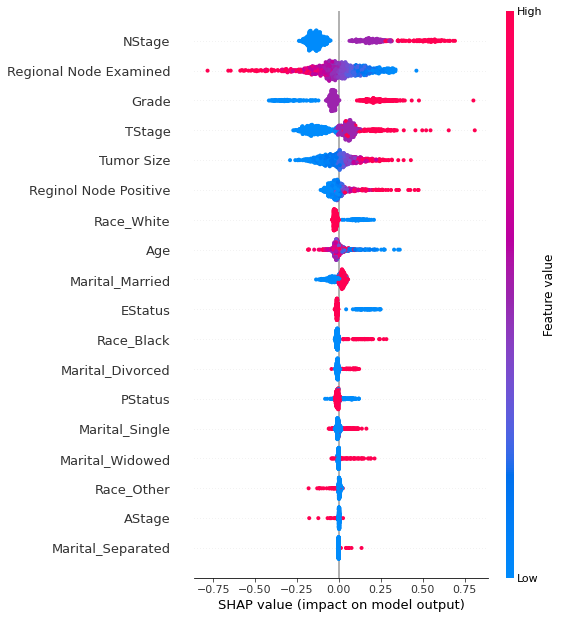

In [36]:
#  Visualization
shap.summary_plot(shap_values, features=x_test_tensor.numpy(), feature_names=x_mapper.transformed_names_)

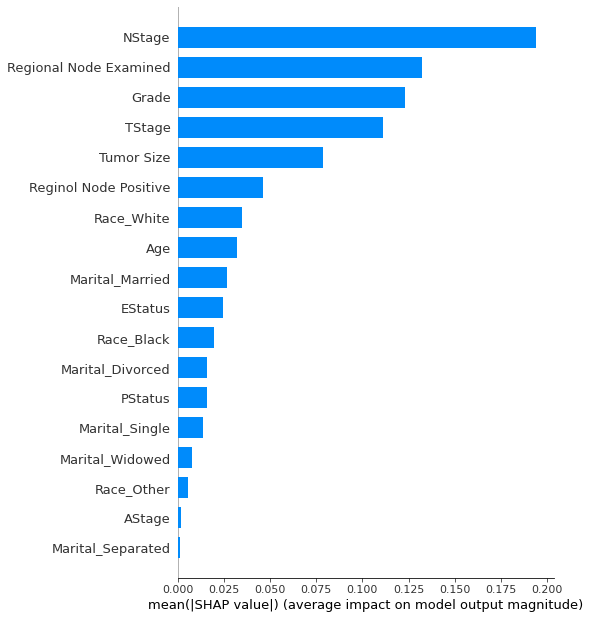

In [40]:
import shap
import torch


shap.summary_plot(shap_values, features=x_test, feature_names=x_mapper.transformed_names_, plot_type='bar')